<a href="https://colab.research.google.com/github/sj-minRva/Multi-omics-Framework-for-Cancer-Classification/blob/main/XGB%2BLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Raw CSV shape (rows x cols): (2700, 1196)
Transposed -> samples x features: (1196, 2700)


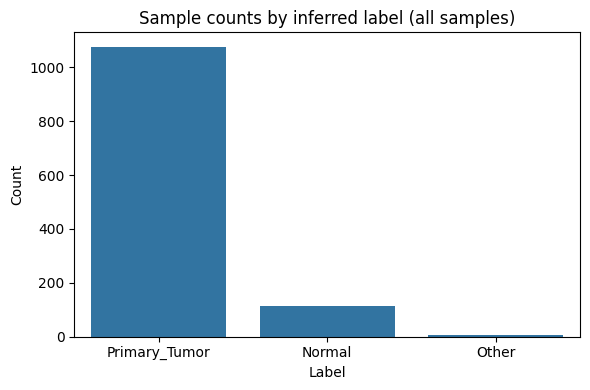


Filtered dataset shape (samples x features): (1189, 2700)
Label distribution:
 binary_label
Primary_Tumor    1076
Normal            113
Name: count, dtype: int64


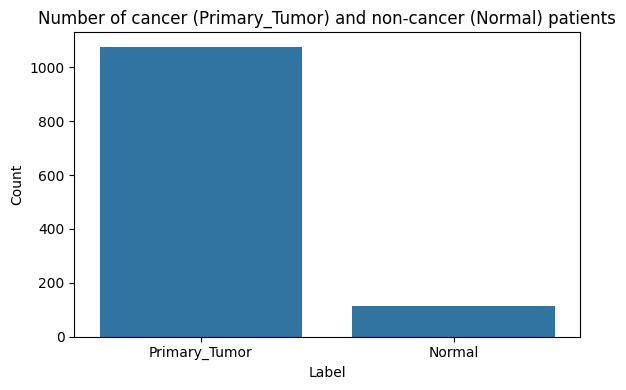

Label mapping: {'Normal': np.int64(0), 'Primary_Tumor': np.int64(1)}
Filled missing feature values with column medians.
Fold 1: Acc=0.9622, AUC=0.9981, Top Feats=500
Fold 2: Acc=0.9916, AUC=0.9990, Top Feats=500
Fold 3: Acc=0.9874, AUC=0.9988, Top Feats=500
Fold 4: Acc=0.9874, AUC=0.9978, Top Feats=500
Fold 5: Acc=0.9747, AUC=0.9951, Top Feats=500

--- Cross-Validation Results ---
   fold  accuracy  precision       auc     kappa  \
0     1  0.962185   1.000000  0.998106  0.809600   
1     2  0.991597   1.000000  0.998989  0.953669   
2     3  0.987395   1.000000  0.998787  0.931779   
3     4  0.987395   1.000000  0.997776  0.931779   
4     5  0.974684   0.995261  0.995137  0.861024   

                                        top_features  
0  [MMP11, FMO2, BMX, MYOM1, PDK4, ITM2A, MEOX1, ...  
1  [MMP11, PAK5, SCN4A, FMO2, SKAP2, MEOX1, HSD17...  
2  [MMP11, FMO2, MCAM, BMX, ITM2A, PAFAH1B3, CXCL...  
3  [MMP11, CPA1, SLC7A14, FMO2, PPP1R12B, SCN4A, ...  
4  [MMP11, CPA1, BMX, FMO2, 

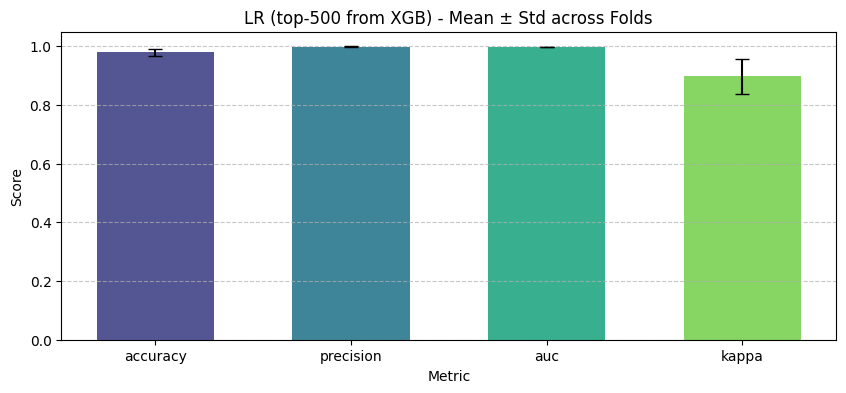


--- Classification Report (Aggregated) ---
               precision    recall  f1-score   support

       Normal       0.84      0.99      0.91       113
Primary_Tumor       1.00      0.98      0.99      1076

     accuracy                           0.98      1189
    macro avg       0.92      0.99      0.95      1189
 weighted avg       0.98      0.98      0.98      1189


Confusion Matrix:
[[ 112    1]
 [  22 1054]]


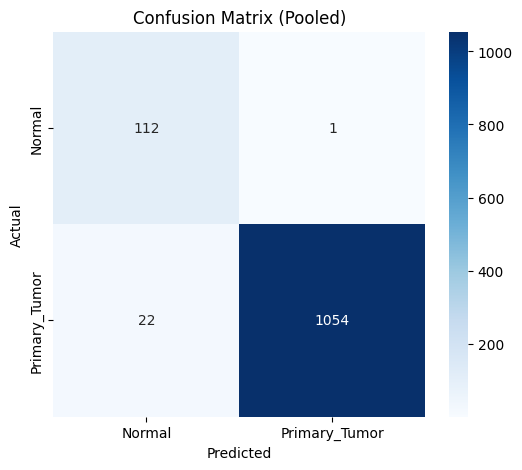


--- ROC Curve (Per-fold + Mean) ---



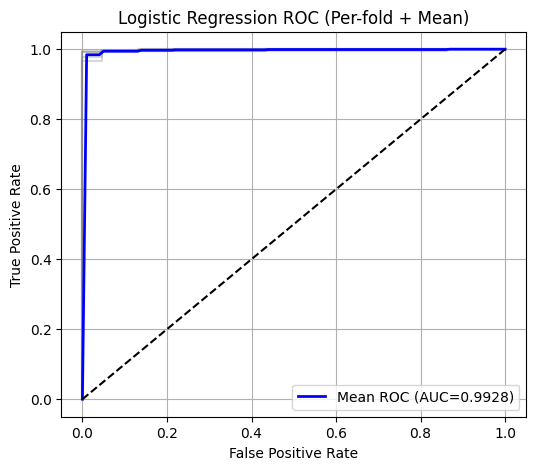

Pooled ROC AUC: 0.9977

Extracting feature importances from the last CV fold (Fold 5)...

Top 20 Features (from last training fold):
 1. MMP11 (importance=0.288891)
 2. CPA1 (importance=0.206889)
 3. BMX (importance=0.114295)
 4. FMO2 (importance=0.081295)
 5. POLR2J (importance=0.073651)
 6. MEOX1 (importance=0.033337)
 7. ITM2A (importance=0.032813)
 8. SLC7A14 (importance=0.019057)
 9. ST6GALNAC1 (importance=0.015507)
10. ABCB5 (importance=0.013634)
11. ALDH18A1 (importance=0.009727)
12. NAALAD2 (importance=0.009662)
13. HSD17B14 (importance=0.008408)
14. SEMA3G (importance=0.007402)
15. CXCL2 (importance=0.007208)
16. RGCC (importance=0.006977)
17. MGLL (importance=0.006020)
18. IBSP (importance=0.005996)
19. P2RX6 (importance=0.005817)
20. RASL10A (importance=0.005306)


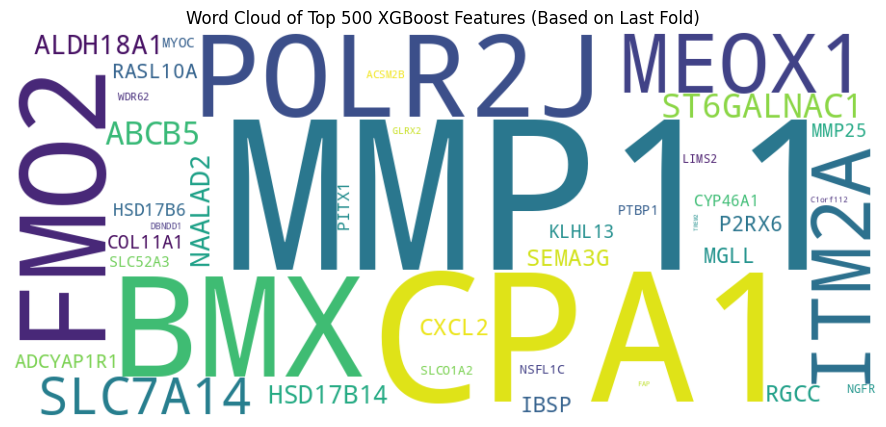


Saved 'top20_xgb_features_last_fold.csv'.


In [5]:
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, roc_auc_score, classification_report,
    confusion_matrix, cohen_kappa_score, roc_curve, auc
)
from xgboost import XGBClassifier

# ----------------- USER CONFIG -----------------
expr_csv_path = r"/content/BRCA_assay_1.csv"
random_state = 42
n_splits = 5
top_k = 500
top_k_for_wordcloud = 500
# ------------------------------------------------

# 0) Load expression CSV
if not os.path.exists(expr_csv_path):
    raise FileNotFoundError(f"Expression CSV not found: {expr_csv_path}")
expr = pd.read_csv(expr_csv_path, index_col=0)
print("Raw CSV shape (rows x cols):", expr.shape)

# 1) Ensure samples x features orientation (samples rows, features columns)
if expr.shape[0] > expr.shape[1]:
    expr = expr.T
    print("Transposed -> samples x features:", expr.shape)
else:
    print("Samples x features:", expr.shape)

# 2) Ensure all column names are strings (fixes scikit-learn TypeError)
# Convert sample IDs to strings
expr.index = expr.index.astype(str).str.strip()
expr.columns = expr.columns.astype(str)

# 3) Ensure all feature columns are numeric (coerce strings to numeric if possible)
non_numeric_cols = [c for c in expr.columns if not pd.api.types.is_numeric_dtype(expr[c])]
if non_numeric_cols:
    print(f"Coercing {len(non_numeric_cols)} non-numeric columns to numeric (may introduce NaNs).")
    expr[non_numeric_cols] = expr[non_numeric_cols].apply(pd.to_numeric, errors='coerce')


# 4) Infer TCGA sample_type code and binary labels from barcodes
def get_sample_type_code(barcode: str):
    if not isinstance(barcode, str):
        return None
    parts = barcode.split('-')
    if len(parts) >= 4 and len(parts[3]) >= 2:
        return parts[3][:2]
    m = re.search(r'-(\d{2}[A-Z0-9])-', barcode)
    if m:
        return m.group(1)[:2]
    return None

sample_type_map = {
    '01': 'Primary_Tumor', '02': 'Recurrent_Tumor', '03': 'Primary_Blood_Derived_Tumor',
    '04': 'Metastatic', '05': 'Additional_Metastatic', '06': 'Metastatic_Recurrent',
    '07': 'Xenograft', '08': 'Cell_Line', '09': 'Primary_Microdissected',
    '10': 'Blood_Derived_Normal', '11': 'Solid_Tissue_Normal', '12': 'Buccal_Cell_Normal'
}

meta = pd.DataFrame(index=expr.index)
meta['sample_type_code'] = [get_sample_type_code(x) for x in expr.index]
meta['sample_type'] = meta['sample_type_code'].map(sample_type_map).fillna('Unknown')
meta['binary_label'] = meta['sample_type'].apply(
    lambda x: 'Primary_Tumor' if x == 'Primary_Tumor' else
              ('Normal' if x in ('Solid_Tissue_Normal', 'Blood_Derived_Normal') else 'Other')
)

# 5) Plot class counts (all samples)
counts = meta['binary_label'].value_counts()
plt.figure(figsize=(6,4))
sns.barplot(x=counts.index, y=counts.values)
plt.title("Sample counts by inferred label (all samples)")
plt.ylabel("Count")
plt.xlabel("Label")
plt.tight_layout()
plt.show()

# 6) Filter to Primary_Tumor vs Normal (binary classification)
mask = meta['binary_label'].isin(['Primary_Tumor', 'Normal'])
expr = expr.loc[mask]
y = meta.loc[mask, 'binary_label']
print("\nFiltered dataset shape (samples x features):", expr.shape)
print("Label distribution:\n", y.value_counts())

# Plot counts (again)
plt.figure(figsize=(6,4))
sns.countplot(x=y)
plt.title("Number of cancer (Primary_Tumor) and non-cancer (Normal) patients")
plt.xlabel("Label")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 7) Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)  # e.g., Normal=0, Primary_Tumor=1
class_names = le.classes_.tolist()
print("Label mapping:", dict(zip(class_names, le.transform(class_names))))

# 8) Impute missing values (median)
if expr.isnull().any().any():
    expr = expr.fillna(expr.median(numeric_only=True))
    print("Filled missing feature values with column medians.")
expr = expr.astype(float)

# 9) ---------- Stratified 5-fold CV with per-fold XGB feature selection ----------
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# Containers to collect metrics
fold_metrics = []
roc_curves = []   # for LR
train_accs = []
val_accs = []

# For aggregated classification report & confusion matrix (pooling predictions across folds)
y_true_pool = []
y_pred_pool = []
y_proba_pool = []

fold_no = 0

for train_idx, test_idx in skf.split(expr, y_enc):
    fold_no += 1
    X_train, X_test = expr.iloc[train_idx], expr.iloc[test_idx]
    y_train, y_test = y_enc[train_idx], y_enc[test_idx]

    # 10) Train XGBoost on training split to get feature importances
    # Note: early_stopping_rounds in .fit() is deprecated in newer XGBoost versions.
    # It is often safer to pass it in the constructor or use callbacks.
    xgb = XGBClassifier(
        n_estimators=200,
        max_depth=6,
        eval_metric='logloss',
        early_stopping_rounds=20, # Added here for XGBoost >= 1.6
        random_state=random_state
    )

    xgb.fit(
        X_train, y_train,
        eval_set=[(X_test, y_test)],
        verbose=False
    )

    # Get importances and choose top_k (from training only)
    importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
    importances_sorted = importances.sort_values(ascending=False)
    k = min(top_k, X_train.shape[1])
    top_feats = importances_sorted.index[:k].tolist()

    # 11) Train Logistic Regression on top features (with scaling)
    scaler = StandardScaler()
    X_train_sel = X_train[top_feats]
    X_test_sel  = X_test[top_feats]

    X_train_scaled = scaler.fit_transform(X_train_sel)
    X_test_scaled  = scaler.transform(X_test_sel)

    lr = LogisticRegression(max_iter=2000, solver='liblinear', class_weight='balanced', random_state=random_state)
    lr.fit(X_train_scaled, y_train)

    # Evaluate
    y_pred = lr.predict(X_test_scaled)
    # Check if predict_proba exists (it usually does for LR), otherwise use decision_function
    if hasattr(lr, "predict_proba"):
        y_proba = lr.predict_proba(X_test_scaled)[:,1]
    else:
        y_proba = lr.decision_function(X_test_scaled)

    # Calculate metrics
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)

    # Handle AUC for binary vs multi-class (assuming binary based on code context)
    if len(np.unique(y_test)) == 2:
        auc_score = roc_auc_score(y_test, y_proba)
    else:
        auc_score = np.nan

    kappa = cohen_kappa_score(y_test, y_pred)

    # --- Store Metrics (Missing in original snippet) ---
    fold_metrics.append({
        'fold': fold_no,
        'accuracy': acc,
        'precision': prec,
        'auc': auc_score,
        'kappa': kappa,
        'top_features': top_feats
    })

    # Store pool data
    y_true_pool.extend(y_test)
    y_pred_pool.extend(y_pred)
    y_proba_pool.extend(y_proba)

    # Store ROC curve data for this fold
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_curves.append((fpr, tpr, auc_score))
    print(f"Fold {fold_no}: Acc={acc:.4f}, AUC={auc_score:.4f}, Top Feats={len(top_feats)}")

# Convert metrics to DataFrame for easy viewing
metrics_df = pd.DataFrame(fold_metrics)
print("\n--- Cross-Validation Results ---")
print(metrics_df)


# 1. Aggregate and Display Metrics
# ---------------------------------------------------------
res_df = pd.DataFrame(fold_metrics)
print("\n--- Per-fold Metrics ---")
print(res_df)

agg = res_df[['accuracy','precision','auc','kappa']].agg(['mean','std']).T
print("\n--- Aggregated Metrics (Mean ± Std) ---")
print(agg)

# Bar Chart of Mean ± Std
metrics_cols = ['accuracy', 'precision', 'auc', 'kappa']
means = res_df[metrics_cols].mean()
stds  = res_df[metrics_cols].std()

plot_df = pd.DataFrame({
    'Metric': means.index,
    'Mean': means.values,
    'Std': stds.values
})


print("\n--- Aggregated Metrics (Mean ± Std) ---")
print(plot_df)

plt.figure(figsize=(10, 4))

# FIX: Use plt.bar instead of sns.barplot
# plt.bar handles pre-calculated 'yerr' correctly without shape errors
bars = plt.bar(
    plot_df['Metric'],
    plot_df['Mean'],
    yerr=plot_df['Std'],
    capsize=5,
    color=sns.color_palette('viridis', len(plot_df)),
    alpha=0.9,
    width=0.6
)

plt.ylim(0, 1.05)
plt.title("LR (top-500 from XGB) - Mean ± Std across Folds")
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# 2. Aggregated Classification Report & Confusion Matrix
# ---------------------------------------------------------
print("\n--- Classification Report (Aggregated) ---")
# Ensure class_names exists
if 'class_names' not in locals():
    class_names = [str(c) for c in np.unique(y_true_pool)]

print(classification_report(y_true_pool, y_pred_pool, target_names=class_names))

# FIX: Calculate confusion matrix 'cm' before plotting
cm = confusion_matrix(y_true_pool, y_pred_pool)
print("\nConfusion Matrix:")
print(cm)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix (Pooled)')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

# 3. ROC Curve: Per-fold + Mean
# ---------------------------------------------------------
print("\n--- ROC Curve (Per-fold + Mean) ---\n")
def plot_mean_roc(roc_list, title='ROC'):
    plt.figure(figsize=(6, 5))
    base_fpr = np.linspace(0, 1, 101)
    tprs = []

    # Plot individual folds
    for item in roc_list:
        # Handle cases where roc_list might have 2 or 3 elements per tuple
        fpr, tpr = item[0], item[1]
        plt.plot(fpr, tpr, color='gray', alpha=0.3)

        # Interpolate to calculate mean
        tpr_interp = np.interp(base_fpr, fpr, tpr)
        tpr_interp[0] = 0.0
        tprs.append(tpr_interp)

    # Plot mean ROC
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(base_fpr, mean_tpr)

    plt.plot(base_fpr, mean_tpr, color='b', lw=2, label=f'Mean ROC (AUC={mean_auc:.4f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='k')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

plot_mean_roc(roc_curves, title='Logistic Regression ROC (Per-fold + Mean)')

# Pooled ROC (Optional check)
try:
    pooled_auc = roc_auc_score(y_true_pool, y_proba_pool)
    fpr_pooled, tpr_pooled, _ = roc_curve(y_true_pool, y_proba_pool)
    print(f"Pooled ROC AUC: {pooled_auc:.4f}")
except Exception as e:
    print(f"Could not compute pooled ROC AUC: {e}")



# 4.--- Feature Importance from the Last Fold (No new training) ---

print(f"\nExtracting feature importances from the last CV fold (Fold {fold_no})...")

#  Get importances from the existing xgb model
feat_imp_last_fold = pd.Series(xgb.feature_importances_, index=X_train.columns).sort_values(ascending=False)
top20 = feat_imp_last_fold.head(20)

print("\nTop 20 Features (from last training fold):")
for i, (name, imp) in enumerate(top20.items(), start=1):
    print(f"{i:2d}. {name} (importance={imp:.6f})")

#  Generate Word Cloud
# Ensure top_k is defined
if 'top_k' not in locals():
    top_k = 500

# We use the weights from the model to determine word size
k_wc = min(top_k, len(feat_imp_last_fold))
freqs = feat_imp_last_fold.head(k_wc).to_dict()

if freqs:
    wc = WordCloud(width=900, height=400, background_color='white').generate_from_frequencies(freqs)

    plt.figure(figsize=(12, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud of Top {k_wc} XGBoost Features (Based on Last Fold)')
    plt.show()

#  Save to CSV
top20.to_csv('top20_xgb_features_last_fold.csv', header=['importance'])
print("\nSaved 'top20_xgb_features_last_fold.csv'.")




